# Assessing Lung Location Network Performance in a Lung Disorder Classification Analysis
***

### Installation and Import of Packages
***

In [ ]:
!pip install lungs_segmentation

In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from bbox_delimiters import bbox_utils
import matplotlib.pyplot as plt
from google.colab import drive 
import urllib.request as url
import seaborn as sn
import pandas as pd
import numpy as np
import random
import cv2

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

### Downloading CheXpert Image Set
***

In [ ]:
drive.mount('/content/gdrive', force_remount = True)
!cp -r /content/gdrive/MyDrive/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

### Pré-processamento nos dados
***

In [4]:
image_size, batch_size = 256, 32
df = pd.read_csv('/content/CheXpert-v1.0-small/train.csv', delimiter = ',')

labels = ['Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Atelectasis', 
          'Pneumothorax', 'Pleural Effusion']

In [5]:
df = df[df['Frontal/Lateral'] == 'Frontal'].copy()
df.drop(labels = 'Frontal/Lateral', axis = 1, inplace = True)

df.drop(labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                  'Fracture', 'Support Devices'], axis = 1, inplace = True)

df = df[(df['AP/PA'] == 'AP') | (df['AP/PA'] == 'PA')].copy()
df.drop(labels = 'AP/PA', axis = 1, inplace = True)
 
df = df[(df['Age'] <= 80) | (df['Age'] >= 10)]
df.drop(labels = 'Age', axis = 1, inplace = True)

df.drop(labels=['Sex', 'Pneumonia', 'Pleural Other'], axis=1, inplace=True)

df.replace(to_replace = float('NaN'), value = 0.0, inplace = True)
df.replace(to_replace = -1.0, value = 0.0, inplace = True)

In [6]:
def count_values(dataframe, label):
  '''
  count the number of positive cases for each of the analyzed classes

  Args:
    dataframe (pandas) --> dataframe with image set information
    label (str) --> name of the disorder under analysis 

  Returns:
    lenght_dataframe (int) --> number of images of the class under analysis

  '''

  return len(dataframe[dataframe[label] == 1.0])

In [7]:
print('{}: {} images'.format(labels[0], count_values(df, labels[0])))
print('{}: {} images'.format(labels[1], count_values(df, labels[1])))
print('{}: {} images'.format(labels[2], count_values(df, labels[2])))
print('{}: {} images'.format(labels[3], count_values(df, labels[3])))
print('{}: {} images'.format(labels[4], count_values(df, labels[4])))
print('{}: {} images'.format(labels[5], count_values(df, labels[5])))
print('{}: {} images'.format(labels[6], count_values(df, labels[6])))

Lung Opacity: 94207 images
Lung Lesion: 7040 images
Edema: 49674 images
Consolidation: 12982 images
Atelectasis: 29718 images
Pneumothorax: 17693 images
Pleural Effusion: 76894 images


In [8]:
lung_opacity = df[(df[labels[0]] == 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

lung_lesion = df[(df[labels[0]] != 1.) & (df[labels[1]] == 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

edema = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] == 1.) & (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) & (df[labels[5]] != 1.) &  (df[labels[6]] != 1.)].index

consolidation = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

atelectasis = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

pneumothorax = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] == 1.) & (df[labels[6]] != 1.)].index
  
pleural_effusion = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] == 1.)].index

In [9]:
print('Individual Labels:\n')
print('{}: {} images'.format(labels[0], len(lung_opacity)))
print('{}: {} images'.format(labels[1], len(lung_lesion)))
print('{}: {} images'.format(labels[2], len(edema)))
print('{}: {} images'.format(labels[3], len(consolidation)))
print('{}: {} images'.format(labels[4], len(atelectasis)))
print('{}: {} images'.format(labels[5], len(pneumothorax)))
print('{}: {} images'.format(labels[6], len(pleural_effusion)))

Individual Labels:

Lung Opacity: 23005 images
Lung Lesion: 1385 images
Edema: 9728 images
Consolidation: 2570 images
Atelectasis: 5088 images
Pneumothorax: 5177 images
Pleural Effusion: 9214 images


In [10]:
df_pure_multilabel = pd.concat((df.drop(lung_opacity), df.drop(lung_lesion), df.drop(edema), df.drop(consolidation),
                                df.drop(atelectasis), df.drop(pneumothorax), df.drop(pleural_effusion)))

In [11]:
print('Images that share more than one label:\n')
print('{}: {} images'.format(labels[0], count_values(df_pure_multilabel, labels[0])))
print('{}: {} images'.format(labels[1], count_values(df_pure_multilabel, labels[1])))
print('{}: {} images'.format(labels[2], count_values(df_pure_multilabel, labels[2])))
print('{}: {} images'.format(labels[3], count_values(df_pure_multilabel, labels[3])))
print('{}: {} images'.format(labels[4], count_values(df_pure_multilabel, labels[4])))
print('{}: {} images'.format(labels[5], count_values(df_pure_multilabel, labels[5])))
print('{}: {} images'.format(labels[6], count_values(df_pure_multilabel, labels[6])))

Images that share more than one label:

Lung Opacity: 636444 images
Lung Lesion: 47895 images
Edema: 337990 images
Consolidation: 88304 images
Atelectasis: 202938 images
Pneumothorax: 118674 images
Pleural Effusion: 529044 images


In [12]:
ts1 = df_pure_multilabel.sample(n = 7040, weights = labels[1], random_state = 42)
ts2 = df_pure_multilabel.drop(ts1.index).sample(n = 7040, weights = labels[3], random_state = 42)
ts3 = df_pure_multilabel.drop(pd.concat([ts1, ts2]).index).sample(n = 7040, weights = labels[5], random_state = 42)
ts4 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3]).index).sample(n = 4000, weights = labels[2], random_state = 42)
ts5 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3, ts4]).index).sample(n = 4000, weights = labels[4], random_state = 42)

df_more_balanced = pd.concat([ts1, ts2, ts3, ts4, ts5])

In [13]:
print('{}: {} images'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} images'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} images'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} images'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} images'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} images'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} images'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 14445 images
Lung Lesion: 7308 images
Edema: 8223 images
Consolidation: 8072 images
Atelectasis: 7788 images
Pneumothorax: 8566 images
Pleural Effusion: 12939 images


In [14]:
lung_opacity = df_more_balanced[(df_more_balanced[labels[0]] == 1.)]
lung_opacity = lung_opacity.sample(n = 8000, random_state = 42)
df_more_balanced.drop(lung_opacity.index, inplace = True)

In [15]:
print('{}: {} images'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} images'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} images'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} images'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} images'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} images'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} images'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 5034 images
Lung Lesion: 4133 images
Edema: 5786 images
Consolidation: 5954 images
Atelectasis: 5645 images
Pneumothorax: 5802 images
Pleural Effusion: 8671 images


In [16]:
pleural_effusion = df_more_balanced[(df_more_balanced[labels[6]] == 1.)]
pleural_effusion = pleural_effusion.sample(n = 2671, random_state = 42)
df_more_balanced.drop(pleural_effusion.index, inplace = True)

In [17]:
print('{}: {} images'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} images'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} images'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} images'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} images'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} images'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} images'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 4145 images
Lung Lesion: 3470 images
Edema: 4646 images
Consolidation: 4685 images
Atelectasis: 4635 images
Pneumothorax: 5146 images
Pleural Effusion: 5405 images


In [18]:
lung_opacity = df[(df[labels[0]] == 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

lung_lesion = df[(df[labels[0]] != 1.) & (df[labels[1]] == 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

edema = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] == 1.) & (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

consolidation = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

atelectasis = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

pneumothorax = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] == 1.) & (df[labels[6]] != 1.)]
  
pleural_effusion = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] == 1.)]

In [19]:
final_df = pd.concat((df_more_balanced, lung_opacity.sample(n = 1855, random_state = 42), lung_lesion, 
                      edema.sample(n = 1354, random_state = 42), consolidation.sample(n = 1315, random_state = 42),
                      atelectasis.sample(n = 1364, random_state = 42), pneumothorax.sample(n = 854, random_state = 42),
                      pleural_effusion.sample(n = 594, random_state = 42)))   

In [20]:
print('{}: {} images'.format(labels[0], count_values(final_df, labels[0])))
print('{}: {} images'.format(labels[1], count_values(final_df, labels[1])))
print('{}: {} images'.format(labels[2], count_values(final_df, labels[2])))
print('{}: {} images'.format(labels[3], count_values(final_df, labels[3])))
print('{}: {} images'.format(labels[4], count_values(final_df, labels[4])))
print('{}: {} images'.format(labels[5], count_values(final_df, labels[5])))
print('{}: {} images'.format(labels[6], count_values(final_df, labels[6])))

Lung Opacity: 6000 images
Lung Lesion: 4855 images
Edema: 6000 images
Consolidation: 6000 images
Atelectasis: 5999 images
Pneumothorax: 6000 images
Pleural Effusion: 5999 images


In [21]:
train_df, test_df = train_test_split(final_df, test_size = 0.1, random_state = 42, shuffle = True)
train_df, valid_df = train_test_split(train_df, test_size = 0.11111, random_state = 42, shuffle = True)

In [25]:
print('Training Images:\n')
print('{}: {} images'.format(labels[0], count_values(train_df, labels[0])))
print('{}: {} images'.format(labels[1], count_values(train_df, labels[1])))
print('{}: {} images'.format(labels[2], count_values(train_df, labels[2])))
print('{}: {} images'.format(labels[3], count_values(train_df, labels[3])))
print('{}: {} images'.format(labels[4], count_values(train_df, labels[4])))
print('{}: {} images'.format(labels[5], count_values(train_df, labels[5])))
print('{}: {} images'.format(labels[6], count_values(train_df, labels[6])))

print('\nTesting Images:\n')
print('{}: {} images'.format(labels[0], count_values(test_df, labels[0])))
print('{}: {} images'.format(labels[1], count_values(test_df, labels[1])))
print('{}: {} images'.format(labels[2], count_values(test_df, labels[2])))
print('{}: {} images'.format(labels[3], count_values(test_df, labels[3])))
print('{}: {} images'.format(labels[4], count_values(test_df, labels[4])))
print('{}: {} images'.format(labels[5], count_values(test_df, labels[5])))
print('{}: {} images'.format(labels[6], count_values(test_df, labels[6])))

print('\nValidation Images:\n')
print('{}: {} images'.format(labels[0], count_values(valid_df, labels[0])))
print('{}: {} images'.format(labels[1], count_values(valid_df, labels[1])))
print('{}: {} images'.format(labels[2], count_values(valid_df, labels[2])))
print('{}: {} images'.format(labels[3], count_values(valid_df, labels[3])))
print('{}: {} images'.format(labels[4], count_values(valid_df, labels[4])))
print('{}: {} images'.format(labels[5], count_values(valid_df, labels[5])))
print('{}: {} images'.format(labels[6], count_values(valid_df, labels[6])))

Training Images:

Lung Opacity: 4803 images
Lung Lesion: 3888 images
Edema: 4832 images
Consolidation: 4832 images
Atelectasis: 4772 images
Pneumothorax: 4757 images
Pleural Effusion: 4772 images

Testing Images:

Lung Opacity: 567 images
Lung Lesion: 488 images
Edema: 574 images
Consolidation: 601 images
Atelectasis: 561 images
Pneumothorax: 657 images
Pleural Effusion: 621 images

Validation Images:

Lung Opacity: 630 images
Lung Lesion: 479 images
Edema: 594 images
Consolidation: 567 images
Atelectasis: 666 images
Pneumothorax: 586 images
Pleural Effusion: 606 images


### Focusing the Lung on Images
***

In [ ]:
train_path, val_path, test_path = list(train_df['Path']), list(valid_df['Path']), list(test_df['Path'])

!cp -r /content/gdrive/MyDrive/lung-localization/vgg/model_vgg5.zip /content/
!unzip /content/model_vgg5.zip
model_loc = tf.keras.models.load_model('/content/content/model_vgg5')

lung_localization = bbox_utils()

In [27]:
for image in train_path:
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = image)
  image_array = cv2.imread(filename = image)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = image)

for image in val_path:
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = image)
  image_array = cv2.imread(filename = image)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = image)

for image in test_path:
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = image)
  image_array = cv2.imread(filename = image)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = image)

### Organizando o gerador de dados
***

In [30]:
train_gen = ImageDataGenerator(rescale = 1./255., shear_range = 0.1, zoom_range = 0.15,
                               rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.05,
                               fill_mode='constant')

train_gen = train_gen.flow_from_dataframe(dataframe = train_df, directory = None,
                                          x_col = 'Path', y_col = labels, class_mode = 'raw',
                                          batch_size = batch_size, target_size = (image_size, image_size))

test_gen = ImageDataGenerator(rescale = 1./255.)

valid_gen = test_gen.flow_from_dataframe(dataframe = valid_df, directory = None, x_col = 'Path',
                                         y_col = labels, class_mode = 'raw', batch_size = batch_size,
                                         target_size = (image_size, image_size))

test_X, test_Y = next(test_gen.flow_from_dataframe(dataframe = test_df, directory = None, x_col = 'Path',
                                                   y_col = labels, class_mode = 'raw', batch_size = 2912,
                                                   target_size = (image_size, image_size)))

Found 20130 validated image filenames.
Found 2517 validated image filenames.
Found 2517 validated image filenames.


In [31]:
labels_editada = ['Opacidade', 'Lesão', 'Edema', 'Consolidação', 'Atelectasia',
                  'Pneumotórax', 'Efusão Pleural']

Text(0, 0.5, 'Imagens')

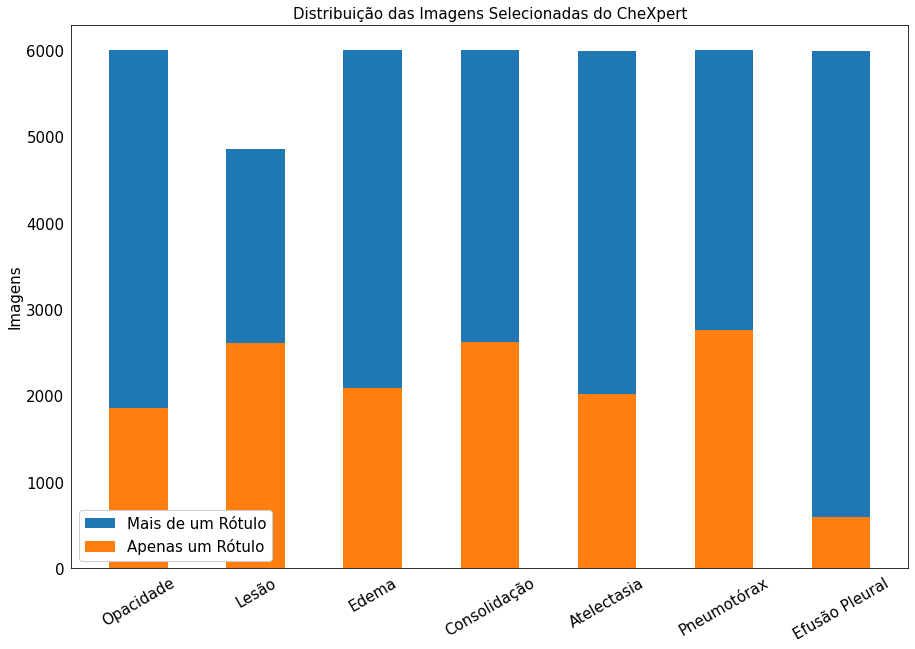

In [34]:
labels_tot = np.concatenate([train_gen.labels, valid_gen.labels, test_Y])

plt.figure(figsize=(15, 10))
plt.xticks(rotation = 30, size = 15)
plt.bar(x = labels_editada, height = np.sum(labels_tot, axis = 0), width = 0.5, label = 'Mais de um Rótulo')
plt.yticks(size = 15)
plt.legend(fontsize = 15, loc = 3, framealpha = 1)

data_analisys = pd.DataFrame(labels_tot)

individual_opacity = data_analisys[(data_analisys[0] == 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                   (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                   (data_analisys[6] != 1.)]

individual_lesion = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] == 1.) & (data_analisys[2] != 1.) &
                                  (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                  (data_analisys[6] != 1.)]

individual_edema = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] == 1.) &
                                 (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                 (data_analisys[6] != 1.)]

individual_consolidation = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                         (data_analisys[3] == 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                         (data_analisys[6] != 1.)]

individual_atelectasis = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                       (data_analisys[3] != 1.) & (data_analisys[4] == 1.) & (data_analisys[5] != 1.) &
                                       (data_analisys[6] != 1.)]

individual_pneumothorax = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                        (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] == 1.) &
                                        (data_analisys[6] != 1.)]

individual_effusion = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                    (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                    (data_analisys[6] == 1.)]

individual = np.array([len(individual_opacity), len(individual_lesion), len(individual_edema), len(individual_consolidation),
                       len(individual_atelectasis), len(individual_pneumothorax), len(individual_effusion)])

plt.rcParams.update({'text.color': "black", 'axes.labelcolor': "black"})
plt.bar(x=labels_editada, height=individual, width=0.5, label = 'Apenas um Rótulo')
plt.legend(fontsize=15, loc=3, framealpha=1)
plt.title('Distribuição das Imagens Selecionadas do CheXpert', size=15, )
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Imagens', size=15, color = 'black')

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text major ticklabel objects>)

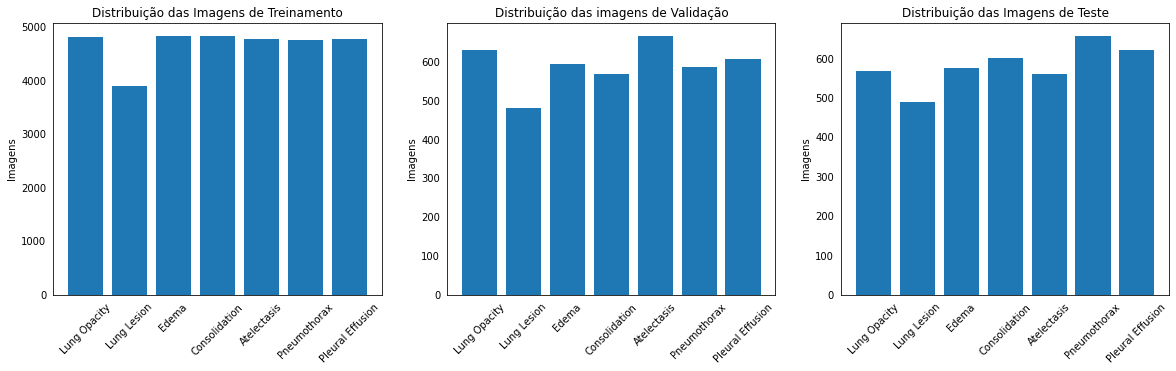

In [43]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(train_gen.labels, axis=0))
plt.title("Distribuição das Imagens de Treinamento")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

plt.subplot(1, 3, 2)
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(valid_gen.labels, axis=0))
plt.title("Distribuição das imagens de Validação")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

plt.subplot(1, 3, 3)
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(test_Y, axis=0))
plt.title("Distribuição das Imagens de Teste")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

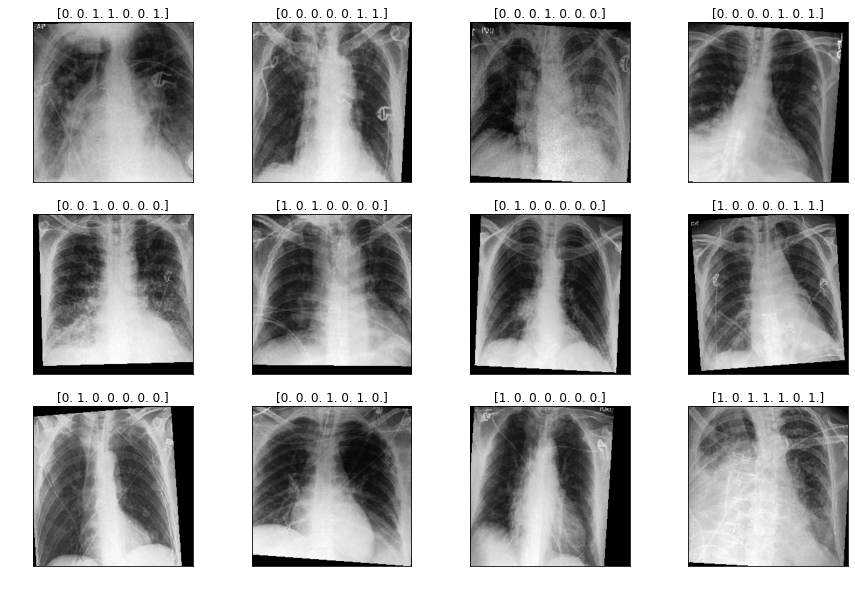

In [49]:
(x, y) = train_gen[random.randrange(0, len(train_gen))]
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (15, 10))
count = 0
for i in range(0, 3):
  for j in range(0, 4):
    axs[i, j].set_title(str(y[count]))
    axs[i, j].imshow(x[count])
    count +=1

In [53]:
def get_callbacks(model_name, monitor = 'val_auc'):
  '''
  define os callbacks do modelo

  Args:
    model name (str) --> nome do modelo em análise
    monitor (str) --> métrica de monitoramento do modelo

  Returns:
    callbacks (list) --> lista de callbacks úteis para o modelo
  '''

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f'model.{model_name}.h5',
                                                  verbose = 1, save_best_only = True, 
                                                  monitor = monitor, mode = 'max')
   
  reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor = monitor, factor = 0.6, min_delta = 1e-5, 
                                                  patience = 2, verbose = 1, mode = 'max')
  
  callbacks = [checkpoint, reducelr]
  
  return callbacks

### Model 1 - DenseNet121
***

In [80]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_densenet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_densenet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                       metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('densenet121', 'val_auc_4')

model_densenet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                   validation_data= valid_gen, epochs = 25, callbacks = callbacks)

Epoch 1/25
629/629 [==============================] - 277s 423ms/step - loss: 0.5135 - auc_4: 0.6577 - val_loss: 0.5550 - val_auc_4: 0.6813

Epoch 00001: val_auc_4 improved from -inf to 0.68133, saving model to model.inceptionv3.h5
Epoch 2/25
629/629 [==============================] - 260s 413ms/step - loss: 0.4911 - auc_4: 0.6998 - val_loss: 0.5387 - val_auc_4: 0.6909

Epoch 00002: val_auc_4 improved from 0.68133 to 0.69091, saving model to model.inceptionv3.h5
Epoch 3/25
629/629 [==============================] - 260s 413ms/step - loss: 0.4825 - auc_4: 0.7144 - val_loss: 0.5926 - val_auc_4: 0.7006

Epoch 00003: val_auc_4 improved from 0.69091 to 0.70057, saving model to model.inceptionv3.h5
Epoch 4/25
629/629 [==============================] - 260s 413ms/step - loss: 0.4734 - auc_4: 0.7285 - val_loss: 0.5505 - val_auc_4: 0.6947

Epoch 00004: val_auc_4 did not improve from 0.70057
Epoch 5/25
629/629 [==============================] - 260s 412ms/step - loss: 0.4678 - auc_4: 0.7369 - va

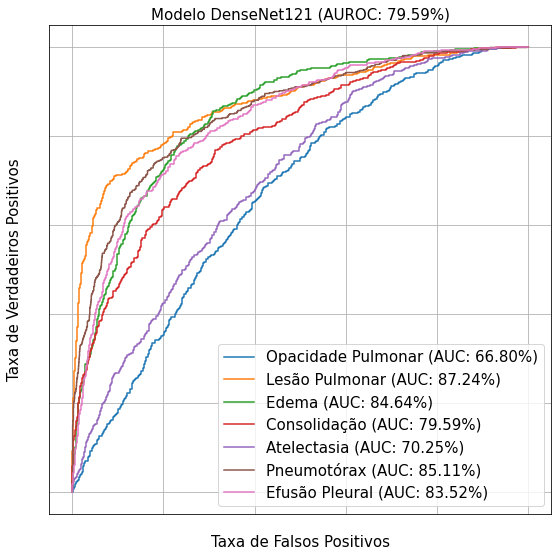

In [82]:
model_densenet.load_weights('/content/model.densenet121.h5')
y_pred = model_densenet.predict(test_X)

fig, c_ax = plt.subplots(nrows = 1, ncols = 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [83]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 15.57%
Erro Absoluto Médio: 21.91%
AUROC: 79.59%


In [ ]:
model_densenet.save('densenet121_model')

### Model 2 - InceptionV3
***

In [86]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_inception = tf.keras.Model(inputs = base_model.input, outputs = output)

model_inception.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                        metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inceptionv3', 'val_auc_5')

model_inception.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                    validation_data= valid_gen, epochs = 25, callbacks = callbacks)

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/25
629/629 [==============================] - 272s 418ms/step - loss: 0.5093 - auc_5: 0.6578 - val_loss: 0.5680 - val_auc_5: 0.6906

Epoch 00001: val_auc_5 improved from -inf to 0.69061, saving model to model.inceptionv3.h5
Epoch 2/25
629/629 [==============================] - 254s 404ms/step - loss: 0.4849 - auc_5: 0.7079 - val_loss: 0.5517 - val_auc_5: 0.7085

Epoch 00002: val_auc_5 improved from 0.69061 to 0.70852, saving model to model.inceptionv3.h5
Epoch 3/25
629/629 [==============================] - 255s 406ms/step - loss: 0.4743 - auc_5: 0.7255 - val_loss: 0.4953 - val_auc_5: 0.7185

Epoch 00003: val_auc_5 improved from 0.70852 to 0.71849, saving model to model.inceptionv3.h5
Epoch 4/25
629/629 [==============================] - 256s 407ms/step - loss: 0.4661 - auc_5: 0.7388 - val_loss: 0.5390 - val_auc_5: 0.7150

Epoch 00004: val_auc_5 did not improve from 0.71849
Epoch 5/25
629/629 [====================

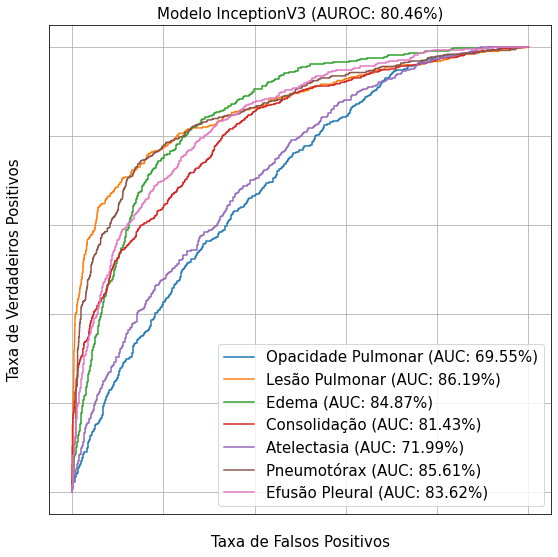

In [87]:
model_inception.load_weights('/content/model.inceptionv3.h5')
y_pred = model_inception.predict(test_X)

fig, c_ax = plt.subplots(nrows = 1, ncols = 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [88]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 14.75%
Erro Absoluto Médio: 21.98%
AUROC: 80.47%


In [ ]:
model_inception.save('inceptionv3_model')

### Model 3 - Xception
***

In [91]:
base_model = Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_xception = tf.keras.Model(inputs = base_model.input, outputs = output)

model_xception.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                        metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('xception', 'val_auc_6')

model_xception.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                   validation_data= valid_gen, epochs = 25, callbacks = callbacks)

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/25
629/629 [==============================] - 332s 518ms/step - loss: 0.4881 - auc_6: 0.7025 - val_loss: 0.5840 - val_auc_6: 0.7176

Epoch 00001: val_auc_6 improved from -inf to 0.71760, saving model to model.xception.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
629/629 [==============================] - 327s 519ms/step - loss: 0.4627 - auc_6: 0.7444 - val_loss: 0.5336 - val_auc_6: 0.7349

Epoch 00002: val_auc_6 improved from 0.71760 to 0.73491, saving model to model.xception.h5
Epoch 3/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4481 - auc_6: 0.7652 - val_loss: 0.4759 - val_auc_6: 0.7545

Epoch 00003: val_auc_6 improved from 0.73491 to 0.75447, saving model to model.xception.h5
Epoch 4/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4349 - auc_6: 0.7824 - val_loss: 0.4950 - val_auc_6: 0.7613

Epoch 00004: val_auc_6 improved from 0.75447 to 0.76131, saving model to model.xception.h5
Epoch 5/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4204 - auc_6: 0.7991 - val_loss: 0.5739 - val_auc_6: 0.7319

Epoch 00005: val_auc_6 did not improve from 0.76131
Epoch 6/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4044 - auc_6: 0.8158 - val_loss

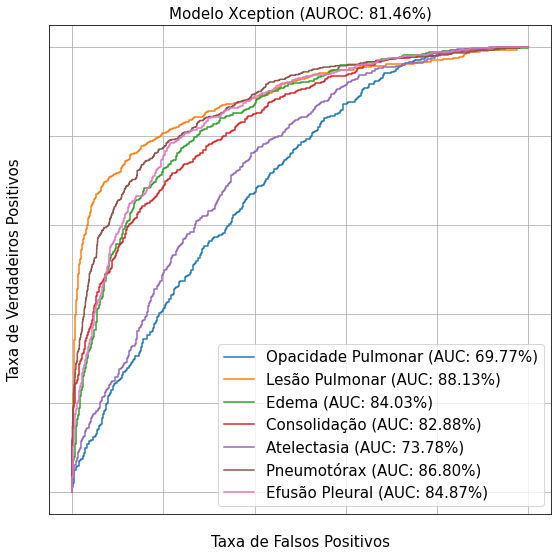

In [94]:
model_xception.load_weights('/content/model.xception.h5')
y_pred = model_xception.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo Xception (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [95]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 15.64%
Erro Absoluto Médio: 21.30%
AUROC: 81.47%


In [ ]:
model_xception.save('xception_model')

### Model 4 - InceptionResNetV2
***

In [98]:
base_model = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_inceptionresnet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_inceptionresnet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                               metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inceptionresnetv2', 'val_auc_7')

model_inceptionresnet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                          validation_data= valid_gen, epochs = 25, callbacks = callbacks)

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/25
629/629 [==============================] - 301s 450ms/step - loss: 0.4927 - auc_7: 0.6962 - val_loss: 0.5036 - val_auc_7: 0.7261

Epoch 00001: val_auc_7 improved from -inf to 0.72606, saving model to model.inceptionresnetv2.h5
Epoch 2/25
629/629 [==============================] - 273s 433ms/step - loss: 0.4665 - auc_7: 0.7397 - val_loss: 0.5276 - val_auc_7: 0.7410

Epoch 00002: val_auc_7 improved from 0.72606 to 0.74096, saving model to model.inceptionresnetv2.h5
Epoch 3/25
629/629 [==============================] - 272s 433ms/step - loss: 0.4558 - auc_7: 0.7557 - val_loss: 0.5452 - val_auc_7: 0.7472

Epoch 00003: val_auc_7 improved from 0.74096 to 0.74716, saving model to model.inceptionresnetv2.h5
Epoch 4/25
629/629 [==============================] - 273s 433ms/step - loss: 0.4439 - auc_7: 0.7713 - val_loss: 0.5446 - val_auc_7: 0.7359

Epoch 00004: val_auc_7 did not improve from 0.74716
Epoch 5/25
629/629 [

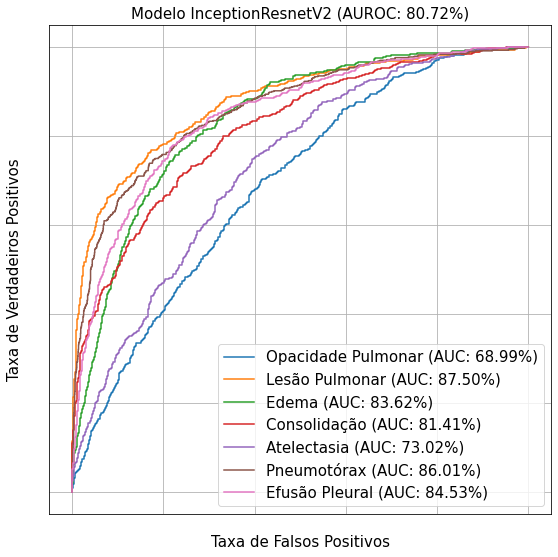

In [103]:
model_inceptionresnet.load_weights('/content/model.inceptionresnetv2.h5')
y_pred = model_inceptionresnet.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo InceptionResnetV2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [104]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 14.91%
Erro Absoluto Médio: 22.36%
AUROC: 80.73%


In [ ]:
model_inceptionresnet.save('inceptionresnetv2_model')

### Model 5 - VGG16
***

In [106]:
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_vgg = tf.keras.Model(inputs = base_model.input, outputs = output)

model_vgg.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                  metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('vgg16', 'val_auc_8')

model_vgg.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
              validation_data= valid_gen, epochs = 25, callbacks = callbacks)

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/25
629/629 [==============================] - 267s 414ms/step - loss: 0.5831 - auc_8: 0.5002 - val_loss: 0.5451 - val_auc_8: 0.5054

Epoch 00001: val_auc_8 improved from -inf to 0.50545, saving model to model.vgg16.h5
Epoch 2/25
629/629 [==============================] - 258s 410ms/step - loss: 0.5454 - auc_8: 0.5007 - val_loss: 0.5443 - val_auc_8: 0.5000

Epoch 00002: val_auc_8 did not improve from 0.50545
Epoch 3/25
629/629 [==============================] - 258s 409ms/step - loss: 0.5425 - auc_8: 0.4987 - val_loss: 0.5442 - val_auc_8: 0.5000

Epoch 00003: val_auc_8 did not improve from 0.50545

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 4/25
629/629 [==============================] - 257s 409ms/step - loss: 0.5420 - auc_8: 0.4982 - val_loss: 0.5442 - val_auc_8: 0.5000

Epoch 00004: val_auc_8 did not improve from 0.50545
Epoch 5/25
629/629 [=============================

KeyboardInterrupt: ignored

In [ ]:
model_vgg.load_weights('/content/model.vgg16.h5')
y_pred = model_vgg.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo VGG16 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [ ]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 14.72%
Erro Absoluto Médio: 28.58%
AUROC: 77.68%


### Model 6 - ResNet101V2
***

In [107]:
base_model = ResNet101V2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_resnet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_resnet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                     metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('resnet101v2', 'val_auc_9')

model_resnet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                 validation_data= valid_gen, epochs = 25, callbacks = callbacks)

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/25
629/629 [==============================] - 280s 427ms/step - loss: 0.5160 - auc_9: 0.6437 - val_loss: 0.5544 - val_auc_9: 0.6666

Epoch 00001: val_auc_9 improved from -inf to 0.66660, saving model to model.resnet101v2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
629/629 [==============================] - 267s 425ms/step - loss: 0.4991 - auc_9: 0.6801 - val_loss: 0.5209 - val_auc_9: 0.6817

Epoch 00002: val_auc_9 improved from 0.66660 to 0.68166, saving model to model.resnet101v2.h5
Epoch 3/25
629/629 [==============================] - 266s 422ms/step - loss: 0.4898 - auc_9: 0.6991 - val_loss: 0.6288 - val_auc_9: 0.6433

Epoch 00003: val_auc_9 did not improve from 0.68166
Epoch 4/25
629/629 [==============================] - 268s 425ms/step - loss: 0.4840 - auc_9: 0.7098 - val_loss: 0.5803 - val_auc_9: 0.6868

Epoch 00004: val_auc_9 improved from 0.68166 to 0.68679, saving model to model.resnet101v2.h5
Epoch 5/25
629/629 [==============================] - 266s 422ms/step - loss: 0.4782 - auc_9: 0.7190 - val_loss: 0.5494 - val_auc_9: 0.6658

Epoch 00005: val_auc_9 did not improve from 0.68679
Epoch 6/25
629/629 [==============================] - 267s 423ms/step - loss: 0.4749 - auc_9: 0.7244 - val_loss: 0.7127 - val_auc_9: 0.6523

Epo

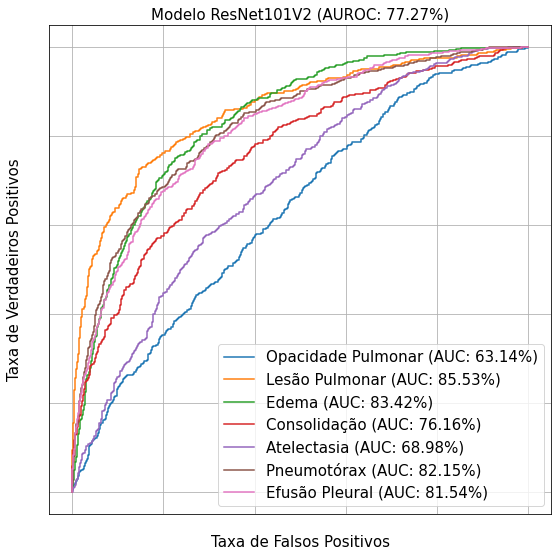

In [108]:
model_resnet.load_weights('/content/model.resnet101v2.h5')
y_pred = model_resnet.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo ResNet101V2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [109]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Mean Square Error: 15.42%
Average Absolute Error: 24.58%
AUROC: 77.27%


In [110]:
model_resnet.save('resnet101v2_model')

INFO:tensorflow:Assets written to: resnet101v2_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Modelo 7 - MobileNetV2
***

In [ ]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
model_mobilenet = tf.keras.Model(base_model.input, output)
model_mobilenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                        metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('mobilenetv2', 'val_auc_9')
model_mobilenet.fit(train_gen,
                    steps_per_epoch = len(train_df) / batch_size,
                    validation_data = valid_gen,
                    epochs = 10,
                    callbacks=callbacks, 
                    use_multiprocessing = True, workers = 8)

In [ ]:
model_mobilenet.load_weights('/content/model.mobilenetv2.h5')

In [ ]:
y_pred = model_mobilenet.predict(test_X)
model_mobilenet.evaluate(test_X, test_Y)

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo MobileNetV2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [ ]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

### Saving Trained models
***

### Média Ponderada - Estratégia de Comitê
***

**NOTA**: Os rótulos verdadeiros do algoritmo foram utilizados  para fins de computar o valor de AUROC, esses que se mantém constantes desde a finalização do treinamento dos algoritmos.

In [111]:
def weighted_average(zip_labels, true_label):
  
  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5 = zip(*zip_labels)

  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5 = np.array(y_pred1), np.array(y_pred2), np.array(y_pred3), np.array(y_pred4), np.array(y_pred5)

  y_pred = (y_pred1 * roc_auc_score(true_label.astype(int), y_pred1) + y_pred2 * roc_auc_score(true_label.astype(int), y_pred2) + y_pred3 * roc_auc_score(true_label.astype(int), y_pred3) + y_pred4 * roc_auc_score(true_label.astype(int), y_pred4) + y_pred5 * roc_auc_score(true_label.astype(int), y_pred5)) / 5

  return y_pred

In [112]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
#y_pred5 = model_vgg.predict(test_X)
y_pred5 = model_resnet.predict(test_X)
#y_pred7 = model_mobilenet.predict(test_X)

zip_labels = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5)

In [113]:
y_pred = weighted_average(zip_labels, test_Y)

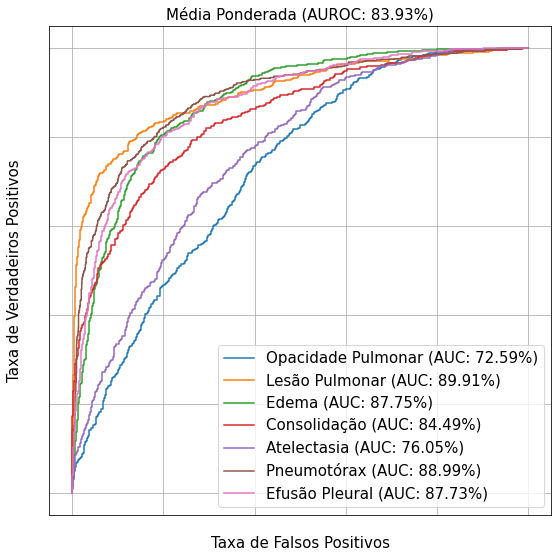

In [114]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Média Ponderada (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [ ]:
!zip -r /content/densenet121_model.zip /content/densenet121_model 
!zip -r /content/inceptionresnetv2_model.zip /content/inceptionresnetv2_model
!zip -r /content/inceptionv3_model.zip /content/inceptionv3_model
!zip -r /content/resnet101v2_model.zip /content/resnet101v2_model
!zip -r /content/xception_model.zip /content/xception_model

In [ ]:
# !mv /content/densenet121_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests
# !mv /content/inceptionresnetv2_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests
# !mv /content/resnet101v2_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests
# !mv /content/inceptionv3_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests
# !mv /content/xception_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests

In [115]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 12.31%
Erro Absoluto Médio: 22.54%
AUROC: 83.93%


### Média Simples - Estratégia de Comitê
***

In [116]:
def average(zip_labels):
  
  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5 = zip(*zip_labels)

  y_pred1, y_pred2, y_pred3, y_pred4, y_pred5 = np.array(y_pred1), np.array(y_pred2), np.array(y_pred3), np.array(y_pred4), np.array(y_pred5)

  y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5) / 5

  return y_pred

In [ ]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
#y_pred5 = model_vgg.predict(test_X)
y_pred5 = model_resnet.predict(test_X)
#y_pred7 = model_mobilenet.predict(test_X)

zip_labels = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5)

In [ ]:
y_pred = average(zip_labels)

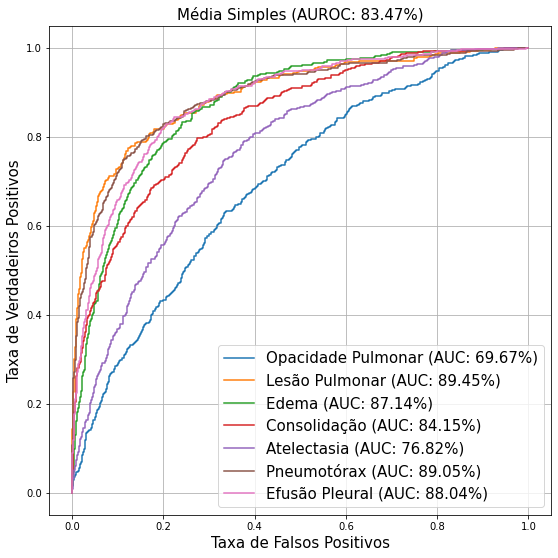

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Média Simples (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

# OBSERVAÇÃO: os resultados não se mostraram superiores a média ponderada

### Voto da Maioria - Estratégia de Comitê
***

**NOTA**: Os rótulos verdadeiros do algoritmo foram utilizados  para fins de computar o valor de AUROC, esses que se mantém constantes desde a finalização do treinamento dos algoritmos.

In [ ]:
def threshold_label(label, threshold):

  binarize_label = np.zeros(label.shape)
  for i in range(0, len(label)):
    if label[i] >= threshold:
      binarize_label[i] = 1
  
  return binarize_label

def threshold_labels(labels, threshold):

  binarize_labels = np.zeros(labels.shape)
  for i in range (0, len(labels)):
    binarize_labels[i] = threshold_label(labels[i], threshold)

  return binarize_labels

def count_frequency(zip_labels):

  (pred1, pred2, pred3, pred4, pred5, pred6, pred7) = zip(*zip_labels)

  frequency = np.sum([np.array(pred1), np.array(pred2), np.array(pred3), np.array(pred4), np.array(pred5), np.array(pred6), np.array(pred7)], axis=0)

  return frequency
 
def majority_vote(frequency, threshold_vote, zip_continuous, test_Y):

  (y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7) = zip(*zip_continuous)
  zip_continuous = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)
  mp = weighted_average(zip_continuous, test_Y)

  majority = np.zeros((frequency.shape))
  for i in range(0, len(frequency)):
    flatten_columns = np.squeeze(np.array([[y_pred1[i]], [y_pred2[i]], [y_pred3[i]], [y_pred4[i]],[y_pred5[i]], [y_pred6[i]], [y_pred7[i]]]))
    indexes = np.argmax(flatten_columns, axis=0)
    for j in range(0, frequency.shape[1]):
      if frequency[i][j] >= threshold_vote:
        majority[i][j] = flatten_columns[indexes[j]][j]
      else:
        majority[i][j] = mp[i][j]
        
  return majority

In [ ]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
y_pred5 = model_vgg.predict(test_X)
y_pred6 = model_resnet.predict(test_X)
y_pred7 = model_mobilenet.predict(test_X)

In [ ]:
for i in range (0, 100):
  for j in range (1, 8):
    threshold = i / 100
    threshold_vote = j
    y_pred1_bin = threshold_labels(y_pred1, threshold)
    y_pred2_bin = threshold_labels(y_pred2, threshold)
    y_pred3_bin = threshold_labels(y_pred3, threshold)
    y_pred4_bin = threshold_labels(y_pred4, threshold)
    y_pred5_bin = threshold_labels(y_pred5, threshold)
    y_pred6_bin = threshold_labels(y_pred6, threshold)
    y_pred7_bin = threshold_labels(y_pred7, threshold)

    zip_labels = zip(y_pred1_bin, y_pred2_bin, y_pred3_bin, y_pred4_bin, y_pred5_bin, y_pred6_bin, y_pred7_bin)
    zip_continuous = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)
    frequency = count_frequency(zip_labels)
    y_pred_mv = majority_vote(frequency, threshold_vote, zip_continuous, test_Y)
   
    print('{}, {}: {}'.format(i/100, j, roc_auc_score(test_Y.astype(int), y_pred_mv)))

0.0, 1: 0.8214212083285757
0.0, 2: 0.8214212083285757
0.0, 3: 0.8214212083285757
0.0, 4: 0.8214212083285757
0.0, 5: 0.8214212083285757
0.0, 6: 0.8214212083285757
0.0, 7: 0.8214212083285757
0.01, 1: 0.8214109610804101
0.01, 2: 0.8214655379149383
0.01, 3: 0.8218112107452997
0.01, 4: 0.8217670319833228
0.01, 5: 0.8241958147742466
0.01, 6: 0.8261509580588902
0.01, 7: 0.8284910060722648
0.02, 1: 0.8214087328758292
0.02, 2: 0.8217731822558575
0.02, 3: 0.8221482309547651
0.02, 4: 0.8232261582615187
0.02, 5: 0.8256817329848571
0.02, 6: 0.8275439268193827
0.02, 7: 0.8302678941605299
0.03, 1: 0.8214065619593897
0.03, 2: 0.8219882193074259
0.03, 3: 0.8228876493852132
0.03, 4: 0.8243766645172986
0.03, 5: 0.8262328487819198
0.03, 6: 0.8285340697534795
0.03, 7: 0.8314828965105131
0.04, 1: 0.8214120747899403
0.04, 2: 0.8222888287463567
0.04, 3: 0.8232275241000684
0.04, 4: 0.8251710994574118
0.04, 5: 0.82704987643329
0.04, 6: 0.8299877174848476
0.04, 7: 0.8324080372611672
0.05, 1: 0.8214127769378827
0

In [ ]:
def majority_vote(frequency, threshold_vote, zip_continuous):

  (y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7) = zip(*zip_continuous)

  majority = np.zeros((frequency.shape))
  for i in range(0, len(frequency)):
    flatten_columns = np.squeeze(np.array([[y_pred1[i]], [y_pred2[i]], [y_pred3[i]], [y_pred4[i]],[y_pred5[i]], [y_pred6[i]], [y_pred7[i]]]))
    indexes = np.argmax(flatten_columns, axis=0)
    for j in range(0, frequency.shape[1]):
      if frequency[i][j] >= threshold_vote:
        majority[i][j] = flatten_columns[indexes[j]][j]
      else:
        majority[i][j] = 0
        
  return majority

In [ ]:
for i in range (0, 100):
  for j in range (1, 8):
    threshold = i / 100
    threshold_vote = j
    y_pred1_bin = threshold_labels(y_pred1, threshold)
    y_pred2_bin = threshold_labels(y_pred2, threshold)
    y_pred3_bin = threshold_labels(y_pred3, threshold)
    y_pred4_bin = threshold_labels(y_pred4, threshold)
    y_pred5_bin = threshold_labels(y_pred5, threshold)
    y_pred6_bin = threshold_labels(y_pred6, threshold)
    y_pred7_bin = threshold_labels(y_pred7, threshold)

    zip_labels = zip(y_pred1_bin, y_pred2_bin, y_pred3_bin, y_pred4_bin, y_pred5_bin, y_pred6_bin, y_pred7_bin)
    zip_continuous = zip(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7)
    frequency = count_frequency(zip_labels)
    y_pred_mv = majority_vote(frequency, threshold_vote, zip_continuous)
   
    print('{}, {}: {}'.format(i/100, j, roc_auc_score(test_Y.astype(int), y_pred_mv)))

0.0, 1: 0.8214212083285757
0.0, 2: 0.8214212083285757
0.0, 3: 0.8214212083285757
0.0, 4: 0.8214212083285757
0.0, 5: 0.8214212083285757
0.0, 6: 0.8214212083285757
0.0, 7: 0.8214212083285757
0.01, 1: 0.8214156363873857
0.01, 2: 0.8214375583252238
0.01, 3: 0.8218097909906233
0.01, 4: 0.8213320269228225
0.01, 5: 0.8230270770640639
0.01, 6: 0.8190583294154042
0.01, 7: 0.7939594372356777
0.02, 1: 0.8213765032787161
0.02, 2: 0.8217592032424296
0.02, 3: 0.821834624301751
0.02, 4: 0.8220718458515329
0.02, 5: 0.8222058216103806
0.02, 6: 0.813058317638193
0.02, 7: 0.778562477237885
0.03, 1: 0.8213232051565822
0.03, 2: 0.821819894644201
0.03, 3: 0.8224469605675508
0.03, 4: 0.8219658051699689
0.03, 5: 0.8194144245225647
0.03, 6: 0.8067816614195765
0.03, 7: 0.76582214663323
0.04, 1: 0.8213521670833314
0.04, 2: 0.8220436505975697
0.04, 3: 0.8219564585961853
0.04, 4: 0.8213799120935078
0.04, 5: 0.8166894769420271
0.04, 6: 0.8018210550618494
0.04, 7: 0.7529275408716913
0.05, 1: 0.8212991571934015
0.05,

### Tempo de Inferência (ms)
***

In [ ]:
import time

In [ ]:
image = test_X[0].reshape(1,256,256,3)

In [ ]:
start_time = time.time()
model_densenet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.06946539878845215


In [ ]:
start_time = time.time()
model_inception.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.05205512046813965


In [ ]:
start_time = time.time()
model_xception.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.04483962059020996


In [ ]:
start_time = time.time()
model_inceptionresnet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.06449627876281738


In [ ]:
start_time = time.time()
model_vgg.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.041649818420410156


In [ ]:
start_time = time.time()
model_resnet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.05455327033996582


In [ ]:
start_time = time.time()
model_mobilenet.predict(image)
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.047670841217041016


In [ ]:
start_time = time.time()
y_pred1 = model_densenet.predict(image)
y_pred2 = model_inception.predict(image)
y_pred3 = model_xception.predict(image)
y_pred4 = model_inceptionresnet.predict(image)
y_pred5 = model_vgg.predict(image)
y_pred6 = model_resnet.predict(image)
y_pred7 = model_mobilenet.predict(image)
y_pred = (y_pred1 * 0.754 + y_pred2 * 0.755 + y_pred3 * 0.762 + y_pred4 * 0.762 + y_pred5 * 0.760 + y_pred6 * 0.749 + y_pred7 * 0.73) / 7
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.3367161750793457


In [ ]:
start_time = time.time()
y_pred1 = model_densenet.predict(image)
y_pred2 = model_inception.predict(image)
y_pred3 = model_xception.predict(image)
y_pred4 = model_inceptionresnet.predict(image)
y_pred5 = model_vgg.predict(image)
y_pred6 = model_resnet.predict(image)
y_pred7 = model_mobilenet.predict(image)
y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6 + y_pred7) / 7
end_time = time.time()

print('Tempo de Inferência: {}'.format(end_time - start_time))

Tempo de Inferência: 0.30196118354797363


### Comparação Ilustrativa dos resultados
***

In [ ]:
auc_densenet = [63.55, 81.12, 82.86, 74.62, 68.87, 81.67, 84.84]
auc_inception = [61.83, 86.47, 83.64, 77.21, 71.82, 86.31, 84.23]
auc_xception = [63.47, 86.63, 83.91, 81.25, 72.36, 84.90, 84.41]
auc_inceptionresnet = [67.69, 88.26, 85.17, 79.68, 72.94, 86.17, 84.71]
auc_vgg = [62.06, 83.62, 82.95, 77.01, 69.74, 83.96, 84.98]
auc_resnet = [63.86, 85.65, 84.49, 79.44, 70.72, 83.68, 84.90]
auc_mobilenet = [63.35, 82.60, 83.15, 74.53, 67.02, 82.04, 79.86]
auc_media_simples = [69.67, 89.45, 87.14, 84.15, 76.82, 89.05, 88.04]
auc_media_ponderada = [69.70, 89.47, 87.14, 84.16, 76.85, 89.07, 88.06]

Text(0.5, 1.0, 'Valores de AUC para cada uma das classes')

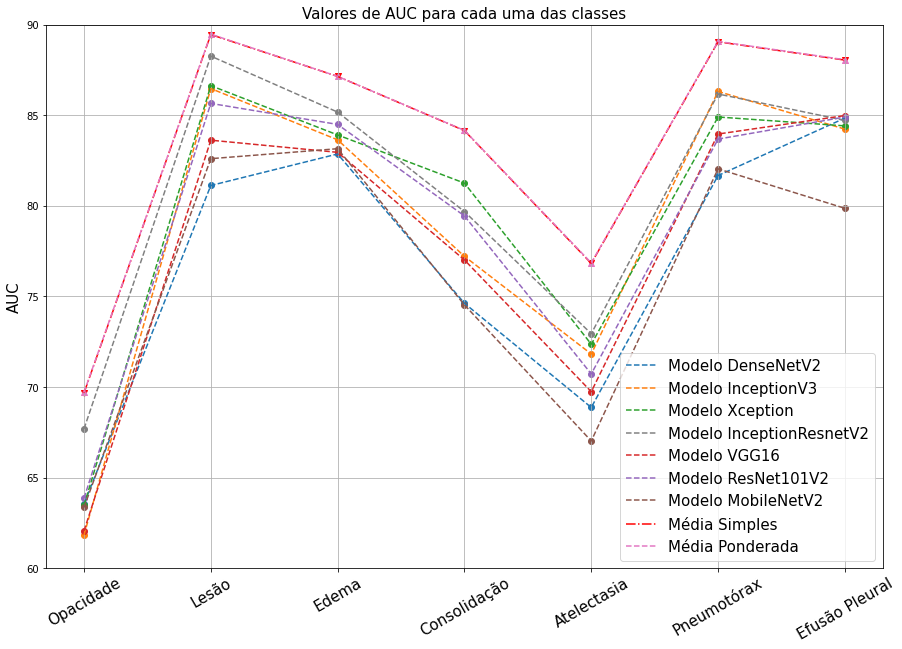

In [ ]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=30, size=15)
plt.ylabel('AUC', size=15)
plt.ylim((60,90))
plt.scatter(labels_editada,auc_densenet)
plt.plot(labels_editada,auc_densenet, '--', label='Modelo DenseNetV2')
plt.scatter(labels_editada,auc_inception)
plt.plot(labels_editada,auc_inception, '--', label='Modelo InceptionV3')
plt.scatter(labels_editada,auc_xception)
plt.plot(labels_editada,auc_xception, '--', label='Modelo Xception')
plt.scatter(labels_editada,auc_inceptionresnet, color='grey')
plt.plot(labels_editada,auc_inceptionresnet, '--', label='Modelo InceptionResnetV2', color='grey')
plt.scatter(labels_editada,auc_vgg)
plt.plot(labels_editada,auc_vgg, '--', label='Modelo VGG16')
plt.scatter(labels_editada,auc_resnet)
plt.plot(labels_editada,auc_resnet, '--', label='Modelo ResNet101V2')
plt.scatter(labels_editada,auc_mobilenet)
plt.plot(labels_editada,auc_mobilenet, '--', label='Modelo MobileNetV2')
plt.scatter(labels_editada,auc_media_simples, marker='v', color='red')
plt.plot(labels_editada,auc_media_simples, '-.', label='Média Simples', color='red')
plt.scatter(labels_editada,auc_media_ponderada, marker = '^')
plt.plot(labels_editada,auc_media_ponderada, '--', label='Média Ponderada')
plt.grid()
plt.legend(fontsize=15)
plt.title('Valores de AUC para cada uma das classes', size=15)